In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import random
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import PIL
from PIL import Image
import tensorflow  as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, UpSampling2D, Conv2D, BatchNormalization
from tensorflow.keras.layers import LeakyReLU, Dropout, ZeroPadding2D, Flatten, Activation
from tensorflow.keras.optimizers import Adam
import tqdm
import warnings
warnings.filterwarnings("ignore")\

Found 2000 files belonging to 1 classes.


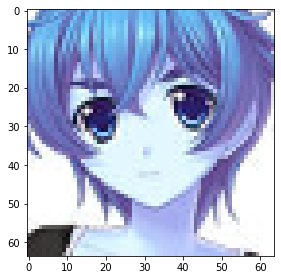

In [3]:
file_path = "/content/drive/MyDrive/GWU/STAT6289/anime face 2000"
batch_s = 64
Anime_face = tf.keras.preprocessing.image_dataset_from_directory(
    file_path, label_mode = None, image_size = (64,64), batch_size = batch_s)
plt.figure(figsize=(4,4))
image = cv2.imread("/content/drive/MyDrive/GWU/STAT6289/anime face 2000/1212.png")
plt.imshow(image)
plt.tight_layout()

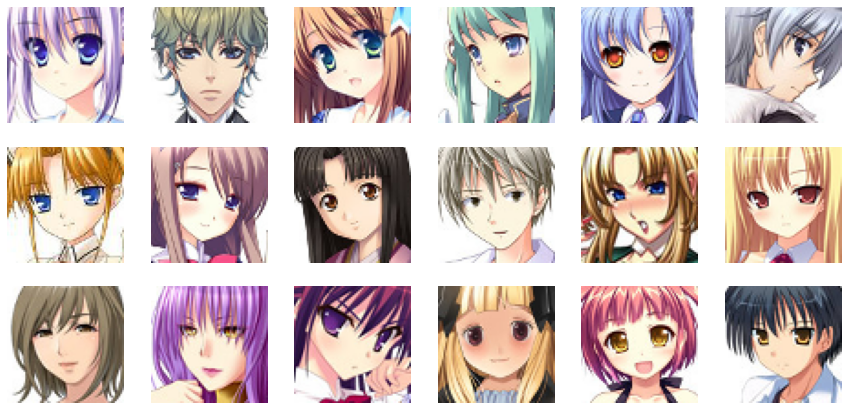

In [4]:
def Show_Img(Anime_face):
    plt.figure(figsize=(15,15))
    for images in Anime_face.take(1):
        for i in range(18):
            ax = plt.subplot(6, 6, i + 1)
            ax.imshow(images[i].numpy().astype("uint8"))
            ax.axis("off")           
Show_Img(Anime_face)

In [5]:
Anime_face = Anime_face.map(lambda x: x / 255.0)
Anime_face

<MapDataset element_spec=TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None)>

###Building a Generator

In [6]:
latent_dim = 100
g_resolution=2

modelG = Sequential()
modelG.add(Dense(4*4*256,activation="relu",input_dim=latent_dim))
modelG.add(Reshape((4,4,256)))
modelG.add(UpSampling2D())
modelG.add(Conv2D(256,kernel_size=3,padding="same"))
modelG.add(BatchNormalization(momentum=0.8))
modelG.add(Activation("relu"))
modelG.add(UpSampling2D())
modelG.add(Conv2D(256,kernel_size=3,padding="same"))
modelG.add(BatchNormalization(momentum=0.8))
modelG.add(Activation("relu"))
modelG.add(UpSampling2D())
modelG.add(Conv2D(256,kernel_size=3,padding="same"))#
modelG.add(BatchNormalization(momentum=0.8))
modelG.add(Activation("relu"))
modelG.add(UpSampling2D())
modelG.add(Conv2D(128,kernel_size=3,padding="same"))
modelG.add(BatchNormalization(momentum=0.8))
modelG.add(Activation("relu"))
modelG.add(Conv2D(3,kernel_size=3,padding="same"))
modelG.add(Activation("tanh"))

modelG.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4096)              413696    
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 8, 8, 256)        0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 8, 8, 256)         590080    
                                                                 
 batch_normalization (BatchN  (None, 8, 8, 256)        1024      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 8, 8, 256)         0

####Creating a random seed and output from generator

(-0.5, 63.5, 63.5, -0.5)

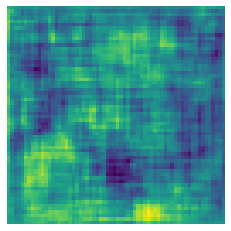

In [7]:
seed = tf.random.normal([1, latent_dim])
Generated_Image = modelG(seed, training=False)

plt.imshow(Generated_Image[0, :, :, 0])
plt.axis("off")

###Building a Discriminator


In [8]:
modelD = Sequential()
modelD.add(Conv2D(32, kernel_size=3, strides=2, input_shape=(64,64,3), padding="same"))
modelD.add(LeakyReLU(alpha=0.2))
modelD.add(Dropout(0.25))
modelD.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
modelD.add(ZeroPadding2D(padding=((0,1),(0,1))))
modelD.add(BatchNormalization(momentum=0.8))
modelD.add(LeakyReLU(alpha=0.2))
modelD.add(Dropout(0.25))
modelD.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
modelD.add(BatchNormalization(momentum=0.8))
modelD.add(LeakyReLU(alpha=0.2))
modelD.add(Dropout(0.25))
modelD.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
modelD.add(BatchNormalization(momentum=0.8))
modelD.add(LeakyReLU(alpha=0.2))
modelD.add(Dropout(0.25))
modelD.add(Conv2D(512, kernel_size=3, strides=1, padding="same"))
modelD.add(BatchNormalization(momentum=0.8))
modelD.add(LeakyReLU(alpha=0.2))
modelD.add(Dropout(0.25))
modelD.add(Flatten())
modelD.add(Dense(1, activation="sigmoid"))

modelD.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 32)        0         
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 zero_padding2d (ZeroPadding  (None, 17, 17, 64)       0         
 2D)                                                             
                                                                 
 batch_normalization_4 (Batc  (None, 17, 17, 64)       256       
 hNormalization)                                      

In [9]:
Discriminator_Verdict = modelD(Generated_Image)
print (Discriminator_Verdict)

tf.Tensor([[0.49970728]], shape=(1, 1), dtype=float32)


In [10]:
class GAN(tf.keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = modelD
        self.generator = modelG
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = tf.keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = tf.keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        
        batch_size = tf.shape(real_images)[0]
        seed = tf.random.normal(shape=(batch_size, self.latent_dim))
      
        generated_images = self.generator(seed)
      
        combined_images = tf.concat([generated_images, real_images], axis=0)
      
        labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)
     
        labels += 0.05 * tf.random.uniform(tf.shape(labels))
    
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

       
        seed = tf.random.normal(shape=(batch_size, self.latent_dim))

   
        misleading_labels = tf.zeros((batch_size, 1))

       
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(seed))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {"d_loss": self.d_loss_metric.result(), "g_loss": self.g_loss_metric.result()}

In [ ]:
epochs = 1000
discriminator_opt = tf.keras.optimizers.Adamax(1.5e-4,0.5)
generator_opt = tf.keras.optimizers.Adamax(1.5e-4,0.5)

loss_fn = tf.keras.losses.BinaryCrossentropy()
model = GAN(discriminator=modelD, generator=modelG, latent_dim=latent_dim)
model.compile(d_optimizer=discriminator_opt, g_optimizer=generator_opt, loss_fn=loss_fn)
history = model.fit(Anime_face, epochs=epochs)

Epoch 1/1000
32/32 [==============================] - 9s 122ms/step - d_loss: 0.6188 - g_loss: 0.7751
Epoch 2/1000
32/32 [==============================] - 4s 111ms/step - d_loss: 0.5782 - g_loss: 0.7732
Epoch 3/1000
32/32 [==============================] - 4s 111ms/step - d_loss: 0.6264 - g_loss: 0.8438
Epoch 4/1000
32/32 [==============================] - 4s 111ms/step - d_loss: 0.6081 - g_loss: 0.8937
Epoch 5/1000
32/32 [==============================] - 4s 111ms/step - d_loss: 0.5478 - g_loss: 1.0470
Epoch 6/1000
32/32 [==============================] - 4s 112ms/step - d_loss: 0.5131 - g_loss: 1.2131
Epoch 7/1000
32/32 [==============================] - 4s 111ms/step - d_loss: 0.5491 - g_loss: 1.1523
Epoch 8/1000
32/32 [==============================] - 4s 114ms/step - d_loss: 0.5872 - g_loss: 1.1084
Epoch 9/1000
32/32 [==============================] - 4s 111ms/step - d_loss: 0.6285 - g_loss: 0.9492
Epoch 10/1000
32/32 [==============================] - 4s 111ms/step - d_loss: 0.5

In [ ]:
history_df = pd.DataFrame(history.history)
fig = plt.figure(figsize=(15,4))
ax=sns.lineplot(data=history_df)
ax.set(xlabel ="Epochs")
ax.set(ylabel ="Loss")
ax.set_title("Learning Curve")

In [ ]:
num_img=25

def Ai_Generator():
    Generated_Paintings = []
    seed = tf.random.normal([num_img, latent_dim])
    generated_image = modelG(seed)
    generated_image *= 255 
    generated_image = generated_image.numpy()
    for i in range(num_img):
            img = tf.keras.preprocessing.image.array_to_img(generated_image[i])
            Generated_Paintings.append(img)
            img.save("/content/drive/MyDrive/GWU/STAT6289/Ai Anime Test 2 150/Image{:02d}.png".format(i)) 
    return 
Images = Ai_Generator()

Found 18 files belonging to 1 classes.


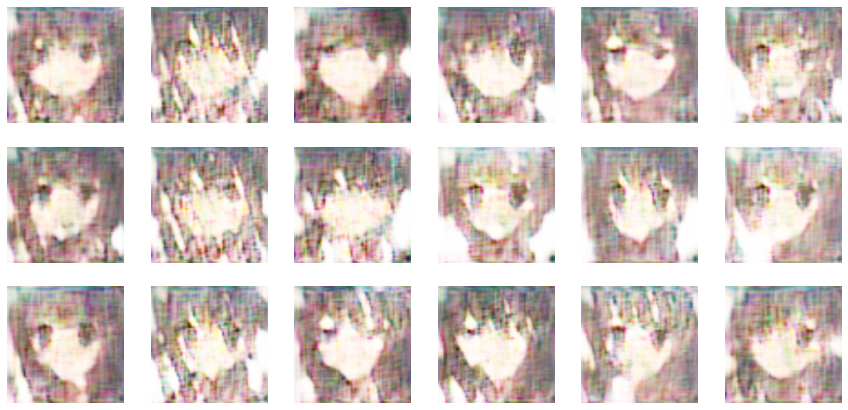

In [ ]:
Generated_path = "/content/drive/MyDrive/GWU/STAT6289/Ai Anime Test 2 150"
Image_generated = tf.keras.preprocessing.image_dataset_from_directory(Generated_path, label_mode = None)
Show_Img(Image_generated)